## Setup (for Colab)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd drive/MyDrive/ai-for-finance/notebooks/

# !pip install scikit-fuzzy

## Description

En este notebook, utilizaremos el dataset `banksim` para entrenar modelos de detección de anomalías. Utilizaremos técnicas no supervisadas y semisupervisadas para detectar anomalías.

## Import libraries

In [141]:
import pandas as pd
import numpy as np
import seaborn as sn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import skfuzzy as fuzz

import matplotlib.pyplot as plt

## Get dataset

In [142]:
df = pd.read_csv('../datasets/banksim_adj.csv')

## Explore dataset

In [143]:
df.columns

Index(['Unnamed: 0', 'age', 'amount', 'fraud', 'M', 'es_barsandrestaurants',
       'es_contents', 'es_fashion', 'es_food', 'es_health', 'es_home',
       'es_hotelservices', 'es_hyper', 'es_leisure', 'es_otherservices',
       'es_sportsandtoys', 'es_tech', 'es_transportation', 'es_travel'],
      dtype='object')

In [144]:
df.head()

,Unnamed: 0,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [145]:
df.fraud.value_counts()

fraud
0    6989
1     200
Name: count, dtype: int64

## Basic preprocessing

In [146]:
y = df.fraud.values.astype(float)
df = df.drop(['Unnamed: 0', 'fraud'], axis=1)

In [147]:
X = df.values.astype(float)

### Data scaling

In [148]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Apply elbow method to find the number of clusters

El método del codo es un método básico para encontrar el número óptimo de clústeres. Hay otros métodos que se pueden usar para encontrar el número óptimo de clústeres, como el método de silhouette.

In [149]:
num_clusters = range(1, 10)

# Apply KMeans algorithm for each value of K
kmeans = [KMeans(n_clusters=k, n_init="auto") for k in num_clusters]

La inercia mide la distancia total al cuadrado entre cada punto en un clúster y el centroide de ese clúster. Proporciona una idea de qué tan compactos son los clústeres, es decir, qué tan cerca están los puntos de datos de los centroides de sus respectivos clústeres

In [150]:
# get the score of each clusterization, also known as inertia
score = [1-kmeans[k].fit(X_scaled).score(X_scaled) for k in range(len(kmeans))]

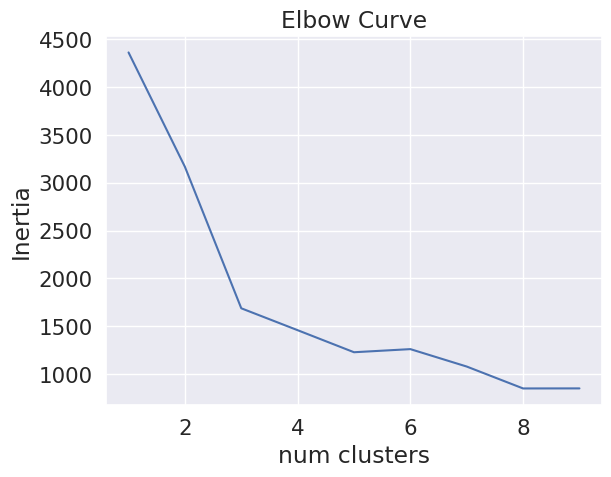

In [151]:
# plot the inertia vs K values to get the elbow
plt.plot(num_clusters, score)
plt.xlabel('num clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

## Split dataset into train and test sets

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### Train and predict with K-Means

In [153]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_train)
X_train_clusters = kmeans.predict(X_train)

In [154]:
# get the cluster centroids
X_trained_clusters_centers = kmeans.cluster_centers_

## Apply the IQR-based outlier detection method

Esta es una aproximación para identificar valores atípicos en un conjunto de datos utilizando el rango intercuartíl(IQR). El IQR es la diferencia entre el percentil 75 (Q3) y el percentil 25 (Q1) de los datos. El IQR se utiliza para identificar valores atípicos definiendo límites en los valores de la muestra que son un factor k del IQR por debajo del percentil 25 o por encima del percentil 75.

In [155]:
# calculate the distance from each point to its respective cluster centroid
dist = [np.linalg.norm(x-y) for x, y in zip(X_train, X_trained_clusters_centers[X_train_clusters])]

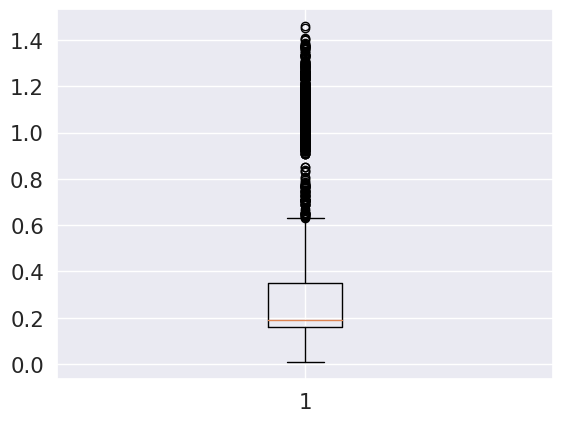

In [156]:
# get the box plot for the distance calculated above
box_plot_data=[dist]
plt.boxplot(box_plot_data)
plt.show()

In [157]:
q75 = np.percentile(dist, 75)
q25 = np.percentile(dist, 25)

print("q75: ", q75)
print("q25: ", q25)

q75:  0.3484373994441168
q25:  0.1602475066473226


In [158]:
# calculate the inter quartile range
iqr = q75-q25
print(iqr)

0.18818989279679418


In [159]:
upper_threshold = q75 + (iqr * 1.5)
print(upper_threshold)

0.6307222386393081


In [160]:
# perform the clustering on the test set
X_test_clusters = kmeans.predict(X_test)

In [161]:
# calculate the distance from each point to its respective cluster centroid for the test set
dist_test = [np.linalg.norm(x-y) for x, y in zip(X_test, X_trained_clusters_centers[X_test_clusters])]

In [162]:
# Let's use the upper_threshold calculated above as the threshold to determine if a point is an anomaly or not
km_y_pred = np.array(dist_test)
km_y_pred[dist_test >= upper_threshold] = 1
km_y_pred[dist_test < upper_threshold] = 0

In [163]:
print(np.sum(km_y_pred))
print(np.sum(y_test))

352.0
58.0


### Calculate the confusion matrix

In [164]:
# calculate the confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred, labels=[1, 0])

In [165]:
# custom function to plot the confusion matrix
def plot_confusion_matrix(km_cm):
    df_cm = pd.DataFrame(km_cm.T, ['Predicted positive','Predicted negative'],['Actual positive','Actual negative'])
    plt.figure(figsize = (8,4))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
    plt.show()

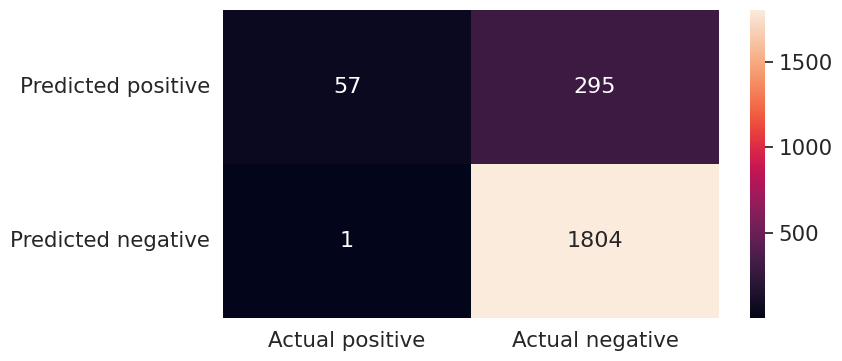

In [166]:
plot_confusion_matrix(km_cm)

## Fuzzy c-means -- a semi-supervised approach

In [167]:
# We only train the model with the non-fraudulent data
X_filtr=X_scaled[y==0]

In [168]:
# let's estimate the number of clusters

# fuzzy partition coefficient
fpcs = []

# fuzzyness coefficient
fuzzy_coefficient = 2


list_num_centers = range(2,10)
for num_centers in list_num_centers:
    centroids, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X_filtr, num_centers, fuzzy_coefficient, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later analysis
    fpcs.append(fpc)

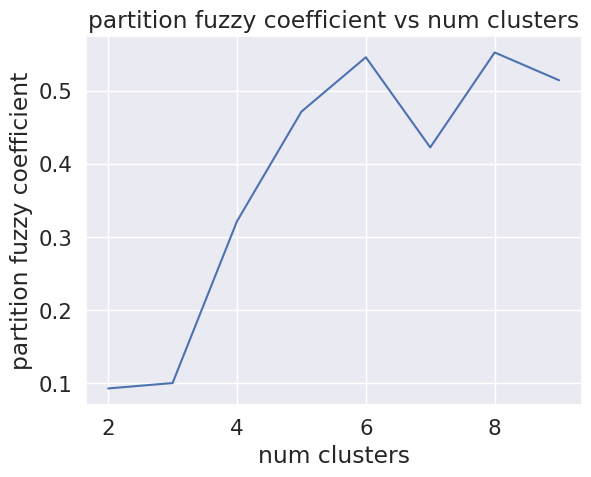

In [169]:
# plot how the fuzzy partition coefficient changes for different number of clusters
plt.plot(list_num_centers, 1-np.array(fpcs))
plt.xlabel('num clusters')
plt.ylabel('partition fuzzy coefficient')
plt.title('partition fuzzy coefficient vs num clusters')
plt.show()

### Train Fuzzy C-Means clustering model

In [170]:
num_centers = 3
centroids, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_filtr.T, num_centers, fuzzy_coefficient, error=0.005, maxiter=1000, init=None)

### Predict with Fuzzy C-Means clustering model

In [171]:
u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(X_train.T, centroids, fuzzy_coefficient, error=0.005, maxiter=1000)

En el método de "Fuzzy C-means", cada punto de datos tiene un coeficiente de membresía para cada clúster. El coeficiente de membresía indica el grado en que un punto de datos pertenece a un clúster. El coeficiente de membresía es un valor entre 0 y 1. Un valor de 1 indica que el punto de datos pertenece al clúster con certeza. Un valor de 0 indica que el punto de datos no pertenece en absoluto al clúster. Un valor entre 0 y 1 indica el grado en que el punto de datos pertenece al clúster.

In [172]:
u.shape

(3, 5032)

In [173]:
cluster_membership = np.argmax(u, axis=0)
max_u = np.max(u,axis=0)
results = pd.DataFrame(u.T, columns=['u1','u2','u3'])

results['cluster_membership'] = cluster_membership
results['max_u'] = max_u
results['fraud'] = y_train

In [174]:
results.head()

,u1,u2,u3,cluster_membership,max_u,fraud
0,0.936866,0.034263,0.028871,0,0.936866,0.0
1,0.708864,0.157479,0.133657,0,0.708864,0.0
2,0.009327,0.984775,0.005898,1,0.984775,0.0
3,0.036484,0.940380,0.023136,1,0.940380,0.0
4,0.154179,0.735875,0.109946,1,0.735875,0.0


In [175]:
anomalies = results[results['fraud']==1]
anomalies.head()

,u1,u2,u3,cluster_membership,max_u,fraud
7,0.232976,0.315600,0.451424,2,0.451424,1.0
36,0.310707,0.230078,0.459216,2,0.459216,1.0
77,0.211893,0.311304,0.476803,2,0.476803,1.0
147,0.284491,0.193462,0.522047,2,0.522047,1.0
178,0.283175,0.206168,0.510657,2,0.510657,1.0


In [176]:
legitimate_transactions = results[results['fraud']==0]
legitimate_transactions.head()

,u1,u2,u3,cluster_membership,max_u,fraud
0,0.936866,0.034263,0.028871,0,0.936866,0.0
1,0.708864,0.157479,0.133657,0,0.708864,0.0
2,0.009327,0.984775,0.005898,1,0.984775,0.0
3,0.036484,0.940380,0.023136,1,0.940380,0.0
4,0.154179,0.735875,0.109946,1,0.735875,0.0


### Box plot of the maximum membership coefficient for each data point

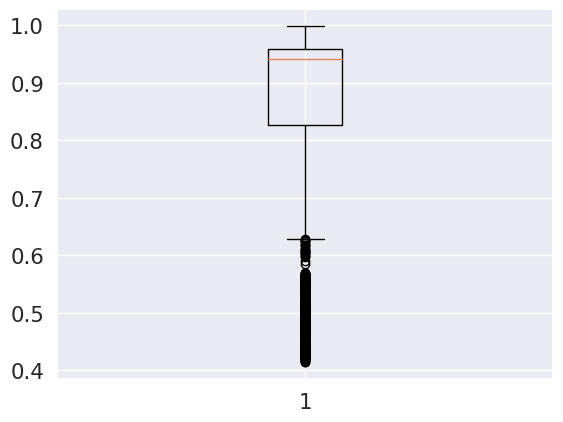

In [177]:
box_plot_data = [results['max_u']]
plt.boxplot(box_plot_data)
plt.show()

### Calculate the upper threshold based on the IQR method

In [179]:
q75 = np.percentile(results['max_u'], 75)
q25 = np.percentile(results['max_u'], 25)
iqr = q75-q25
upper_threshold = q25 - (iqr * 1.5)

### Anomaly detection based on the upper threshold and fuzzy c-means membership coefficient

In [180]:
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_test.T, centroids, fuzzy_coefficient, error=0.005, maxiter=1000)

In [181]:
max_u_test = np.max(u.T,axis=1)
km_y_pred = np.array(max_u_test)
km_y_pred[max_u_test <= upper_threshold] = 1
km_y_pred[max_u_test > upper_threshold] = 0

### Calculate the confusion matrix

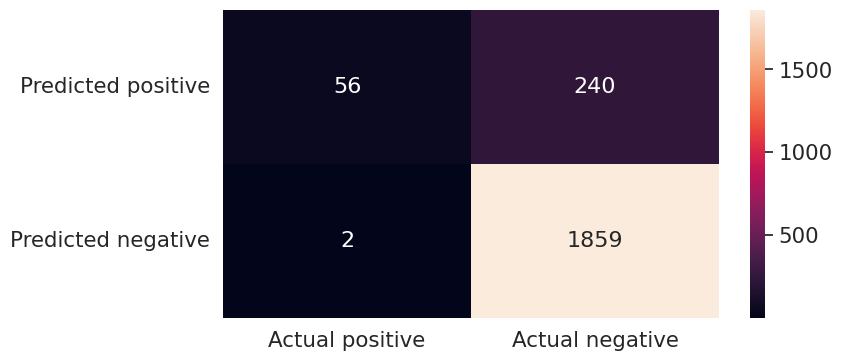

In [182]:
km_cm = confusion_matrix(y_test, km_y_pred, labels=[1, 0])

plot_confusion_matrix(km_cm)